In [97]:
import gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis, filter_unlabeled_dataframe
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
from snorkel.utils import probs_to_preds

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve

from river.tree import HoeffdingTreeClassifier

from tqdm import tqdm

In [2]:
VECTOR_SIZE = 300
WINDOW_SIZE = 10
MIN_COUNT = 2
WORKERS = 12

In [67]:
LABELS = {
    'None': 0,
    'Gain privileges': 1,
    'Sql Injection': 2,
    'Obtain Information': 3,
    'Memory corruption': 4,
    'CSRF': 5,
    'Execute Code': 6,
    'Denial Of Service': 7,
    'Cross Site Scripting': 8,
    'Http response splitting': 9,
    'Directory traversal': 10,
    'Bypass a restriction or similar': 11,
    'Overflow': 12
}
ABSTAIN = -1

In [68]:
all_summaries = pd.read_csv('all_cves.csv')['summary'].to_numpy()

In [69]:
cves = pd.read_csv('cves_labeled.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)

multiple_labels_idxs = [i for i in range(cves.shape[0]) if ',' in cves['labels'][i]]
cves = cves.drop(multiple_labels_idxs).reset_index(drop=True)

In [70]:
# Drop None from data
cves_none = cves[cves['labels'] == 'None'].reset_index(drop=True)
none_summaries = cves_none['summary'].to_list()

none_idxs = [i for i in range(cves.shape[0]) if cves['labels'][i] == 'None']
cves = cves.drop(none_idxs).reset_index(drop=True)

In [71]:
y_true = pd.DataFrame([LABELS[l.strip()] for l in cves['labels'].to_list()])

In [72]:
# Naive labeling functions
# Memory corruption labeling functions
@labeling_function()
def lf_has_memory(x):
    return LABELS['Memory corruption'] if 'memory' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_corruption(x):
    return LABELS['Memory corruption'] if 'corruption' in x.summary.lower() else ABSTAIN


# Gain privileges labeling functions
@labeling_function()
def lf_has_gain(x):
    return LABELS['Gain privileges'] if 'gain' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_privilege(x):
    return LABELS['Gain privileges'] if 'privilege' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_gain_privilege(x):
    return LABELS['Gain privileges'] if 'gain privilege' in x.summary.lower() else ABSTAIN


# Obtain Information labeling functions
@labeling_function()
def lf_has_obtain(x):
    return LABELS['Obtain Information'] if 'obtain' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_information(x):
    return LABELS['Obtain Information'] if 'information' in x.summary.lower() else ABSTAIN

# # None labeling functions
# @labeling_function()
# def lf_has_user(x):
#     return LABELS['None'] if 'user' in x.summary.lower() else ABSTAIN


# Sql Injection labeling functions
@labeling_function()
def lf_has_sql(x):
    return LABELS['Sql Injection'] if 'sql' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_injection(x):
    return LABELS['Sql Injection'] if 'injection' in x.summary.lower() else ABSTAIN


# CSRF labeling functions
@labeling_function()
def lf_has_csrf(x):
    return LABELS['CSRF'] if 'csrf' in x.summary.lower() else ABSTAIN


# Execute Code labeling functions
@labeling_function()
def lf_has_code(x):
    return LABELS['Execute Code'] if 'code' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_execution(x):
    return LABELS['Execute Code'] if 'execution' in x.summary.lower() else ABSTAIN


# Denial Of Service labeling functions
@labeling_function()
def lf_has_denial(x):
    return LABELS['Denial Of Service'] if 'denial' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_service(x):
    return LABELS['Denial Of Service'] if 'service' in x.summary.lower() else ABSTAIN


# Cross Site Scripting labeling functions
@labeling_function()
def lf_has_crosssite(x):
    return LABELS['Cross Site Scripting'] if 'cross-site' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_scripting(x):
    return LABELS['Cross Site Scripting'] if 'scripting' in x.summary.lower() else ABSTAIN


# Http response splitting labeling functions
@labeling_function()
def lf_has_html(x):
    return LABELS['Http response splitting'] if 'html' in x.summary.lower() else ABSTAIN


# Directory traversal labeling functions
@labeling_function()
def lf_has_traversal(x):
    return LABELS['Directory traversal'] if 'traversal' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_directory(x):
    return LABELS['Directory traversal'] if 'directory' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_files(x):
    return LABELS['Directory traversal'] if 'files' in x.summary.lower() else ABSTAIN


# Bypass a restriction or similar labeling functions
@labeling_function()
def lf_has_bypass(x):
    return LABELS['Bypass a restriction or similar'] if 'bypass' in x.summary.lower() else ABSTAIN


# Overflow labeling functions
@labeling_function()
def lf_has_overflow(x):
    return LABELS['Overflow'] if 'overflow' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_buffer(x):
    return LABELS['Overflow'] if 'buffer' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_heap(x):
    return LABELS['Overflow'] if 'heap' in x.summary.lower() else ABSTAIN

In [73]:
lfs = [
    lf_has_memory,
    lf_has_corruption,
    lf_has_gain,
    lf_has_privilege,
    lf_has_gain_privilege,
    lf_has_obtain,
    lf_has_information,
    # lf_has_user,
    lf_has_sql,
    lf_has_injection,
    lf_has_csrf,
    lf_has_code,
    lf_has_execution,
    lf_has_denial,
    lf_has_service,
    lf_has_crosssite,
    lf_has_scripting,
    lf_has_html,
    lf_has_traversal,
    lf_has_directory,
    lf_has_files,
    lf_has_bypass,
    lf_has_overflow,
    lf_has_buffer,
    lf_has_heap,
]
len(lfs)

24

In [74]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=cves)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5460/5460 [00:00<00:00, 14140.38it/s]


In [75]:
# Porcentagem de pontos que cada LF positiva
# coverages = (L_train != ABSTAIN).mean(axis=0)
# lfs_coverages = {lfs[i].__repr__().split(' ')[1].replace(',', ''): coverages[i] for i in range(len(lfs))}

# for key, value in lfs_coverages.items():
#     print(f'{value * 100:06.3f}% -- {key}')

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_has_memory,0,[4],0.080952,0.074542,0.069048
lf_has_corruption,1,[4],0.065385,0.065385,0.059890
lf_has_gain,2,[1],0.046520,0.046520,0.013553
lf_has_privilege,3,[1],0.267399,0.266667,0.233700
lf_has_gain_privilege,4,[1],0.042308,0.042308,0.009707
lf_has_obtain,5,[3],0.313004,0.312088,0.032784
lf_has_information,6,[3],0.397802,0.365934,0.086630
lf_has_sql,7,[2],0.006044,0.006044,0.004396
lf_has_injection,8,[2],0.007143,0.006960,0.005311
lf_has_csrf,9,[5],0.002198,0.001648,0.001648


In [76]:
label_model = LabelModel(cardinality=13, verbose=False)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

probs = label_model.predict_proba(L=L_train)
y = probs_to_preds(probs, tie_break_policy='true-random')

acc, f1_macro = label_model.score(L=L_train, Y=y_true, metrics=['accuracy', 'f1_macro']).values()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 809.19epoch/s]


In [77]:
print('---- Label model metrics')
print(f'Accuracy: {acc}')
print(f'F1 macro: {f1_macro}')
print('----')

---- Label model metrics
Accuracy: 0.826340545625588
F1 macro: 0.5938396623345166
----


In [78]:
def preprocess(data):
    for i in range(len(data)):
        yield gensim.utils.simple_preprocess(data[i])

documents = list(preprocess(all_summaries))

gensim_word2vec = gensim.models.Word2Vec(
    documents,
    vector_size=VECTOR_SIZE,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=WORKERS
)

gensim_word2vec.train(
    documents,
    total_examples=len(documents),
    epochs=10
)

(59354985, 79281720)

In [79]:
sentences = [gensim.utils.simple_preprocess(sentence) for sentence in cves['summary'].to_numpy()]

X = []

for sentence in sentences:
    wvs = []
    
    for word in sentence:
        try:
            wvs.append(gensim_word2vec.wv[word])
        except KeyError:
            wvs.append(np.zeros(VECTOR_SIZE))
            
    X.append(np.mean(wvs, axis=0))

In [108]:
y_true = y_true[0].to_list()

In [135]:
model = HoeffdingTreeClassifier()
STREAM_WINDOW_SIZE = 100

s_preds = []

window_preds = []
window_y_snorkel = []
window_y_true = []

f1s_snorkel = []
f1s_true = []

for i in tqdm(range(len(X)), desc='Stream', ncols=75):
    pred = model.predict_one(X[i])
    
    x = {j: X[i][j] for j in range(len(X[i]))}
    model.learn_one(x, y[i])
    
    if pred is None:
        pred = y[0]
    
    s_preds.append(pred)
    window_preds.append(pred)
    window_y_snorkel.append(y[i])
    window_y_true.append(y_true[i])
    
    if len(window_preds) >= STREAM_WINDOW_SIZE:
        f1s_snorkel.append(f1_score(
            window_y_snorkel,
            window_preds,
            average="macro",
            zero_division=0
        ))
        
        f1s_true.append(f1_score(
            window_y_true,
            window_preds,
            average="macro",
            zero_division=0
        ))
    
        window_preds.pop(0)
        window_y_snorkel.pop(0)
        window_y_true.pop(0)

Stream: 100%|██████████████████████████| 5460/5460 [00:56<00:00, 96.08it/s]


In [112]:
def evaluate(labels, scores):
    print(f'\tAcc: {accuracy_score(labels, scores)}')
    print(f'\tPrecision macro: {precision_score(labels, scores, average="macro", zero_division=0)}')
    print(f'\tPrecision micro: {precision_score(labels, scores, average="micro", zero_division=0)}')
    print(f'\tRecall macro: {recall_score(labels, scores, average="macro", zero_division=0)}')
    print(f'\tRecall micro: {recall_score(labels, scores, average="micro", zero_division=0)}')
    print(f'\tF1 macro: {f1_score(labels, scores, average="macro", zero_division=0)}')
    print(f'\tF1 micro: {f1_score(labels, scores, average="micro", zero_division=0)}')

In [136]:
print(f'\n----Random Forest metrics - with Snorkels preds')
evaluate(y, s_preds)
print('----')
print(f'\n----Random Forest metrics - with true preds')
evaluate(y_true, s_preds)
print('----')


----Random Forest metrics - with Snorkels preds
	Acc: 0.31556776556776556
	Precision macro: 0.05475233606100598
	Precision micro: 0.31556776556776556
	Recall macro: 0.07899830627166887
	Recall micro: 0.31556776556776556
	F1 macro: 0.044958696429650266
	F1 micro: 0.31556776556776556
----

----Random Forest metrics - with true preds
	Acc: 0.3824175824175824
	Precision macro: 0.06555279003857954
	Precision micro: 0.3824175824175824
	Recall macro: 0.08803602741909772
	Recall micro: 0.3824175824175824
	F1 macro: 0.05782316706396731
	F1 micro: 0.3824175824175824
----


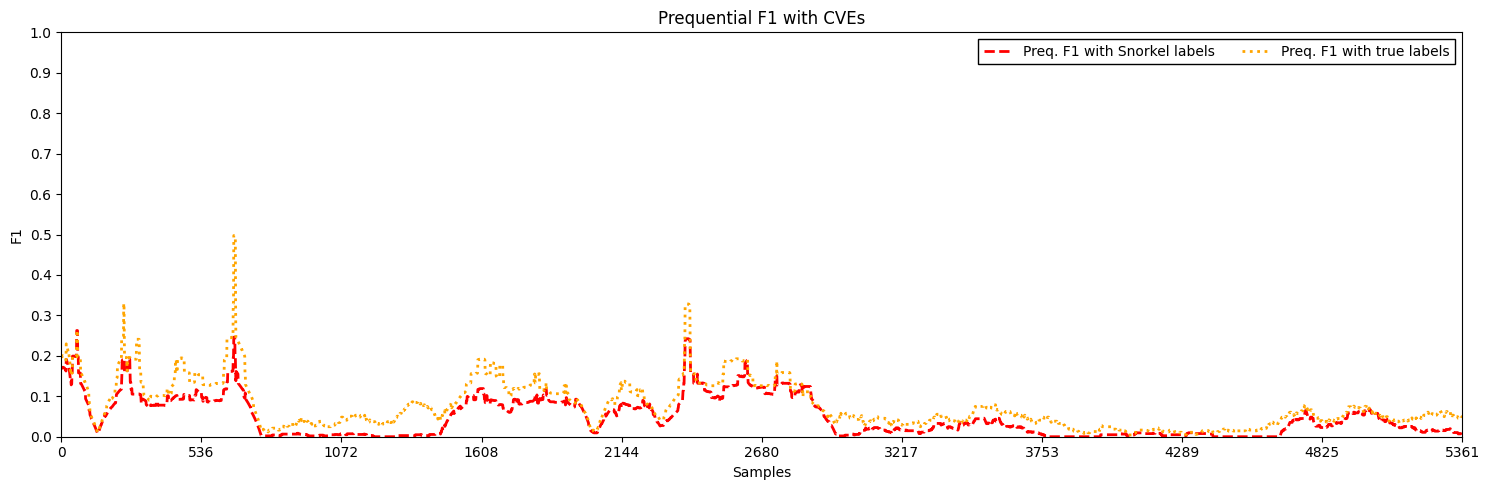

In [137]:
fig, ax = plt.subplots(figsize=(15, 5))

plot_x = range(len(f1s_snorkel))
plt.plot(
    plot_x,
    f1s_snorkel,
    label='Preq. F1 with Snorkel labels',
    color='red',
    antialiased=True,
    linestyle='dashed',
    linewidth=2
)

plt.plot(
    plot_x,
    f1s_true,
    label='Preq. F1 with true labels',
    color='orange',
    antialiased=True,
    linestyle='dotted',
    linewidth=2
)

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, len(plot_x) * 1.1, len(plot_x) * 0.1))
plt.ylim((0, 1))
plt.xlim((0, len(plot_x)))
         
plt.legend(
    ncol=5, loc='best', fancybox=False, framealpha=1,
    borderpad=0.4, edgecolor='black'
)
         
ax.set_xlabel('Samples')
ax.set_ylabel('F1')

plt.title('Prequential F1 with CVEs')
plt.tight_layout()